<a href="https://colab.research.google.com/github/dedeepya-M/covid_prediction/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification of CT images
### To classify the given CT into covid or non-covid

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing all the Essential Libraries

In [ ]:
import pandas as pd
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
import tensorflow as tf
from keras.models import *
from tensorflow.keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D

from keras import backend as keras
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD

copying image paths

In [ ]:
covid_path = "/content/drive/MyDrive/SARS-Cov-2/COVID"
noncov_path = "/content/drive/MyDrive/SARS-Cov-2/non-COVID"

In [ ]:
covid = os.listdir(covid_path) #list of ct images of covid patients
normal = os.listdir(noncov_path) #list of ct images of non covid patients

In [ ]:
print(len(covid))
print(len(normal))

1252
1230


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [ ]:
directory = '/content/drive/MyDrive/SARS-Cov-2'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    shuffle = True,
    batch_size=32,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 2482 files belonging to 2 classes.


In [ ]:
classes = dataset.class_names
classes

['COVID', 'non-COVID']

In [ ]:
len(dataset) # there are 78 batches of 32 images each 

78

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape) #shape of each batch 
    print(labels_batch.numpy())#label of each batch 
    print(image_batch[0].shape)

(32, 256, 256, 3)
[1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0]
(256, 256, 3)


### Data visualization

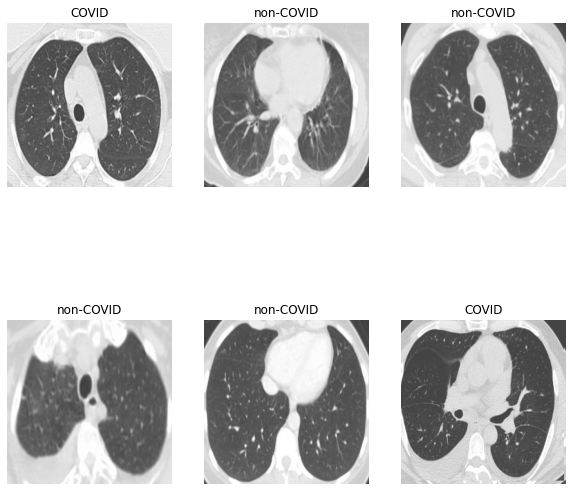

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(6):
    plt.subplot(2,3,1+i)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    
    plt.axis('off')
    plt.title(classes[labels_batch[i]])

### Train Test Validation split
#### 70%----->training data, 20%----->testing data, 10%----->validation

In [ ]:
def data_split(ds,train_len=0.7,test_len=0.2,val_len=0.1,shuffle=True, shuffle_size=10000):
  
  data_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_len*data_size)
  val_size = int(val_len*data_size)
  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)  
  return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds = data_split(dataset)

In [ ]:
print(len(train_ds))
train_ds

54


<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
len(val_ds)

7

In [ ]:
len(test_ds)

17

shuffling the Data

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Resizing and Scaling images

In [ ]:
resize = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augumentaion

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset


In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Implementing VGG16 using Transfer Learning

In [ ]:
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(256,256,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    return model

In [ ]:
model=VGG16()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                  

In [ ]:
Vgg16 = Model(inputs=model.input, outputs=model.get_layer('vgg16').output)

Loading the weights of VGG16

In [ ]:
Vgg16.load_weights("/content/drive/MyDrive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [ ]:
for layer in Vgg16.layers:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7f15bf10b2d0> False
<keras.layers.convolutional.Conv2D object at 0x7f15bf136750> False
<keras.layers.pooling.MaxPooling2D object at 0x7f15b121be10> False
<keras.layers.convolutional.Conv2D object at 0x7f15b1233590> False
<keras.layers.convolutional.Conv2D object at 0x7f15b132a490> False
<keras.layers.pooling.MaxPooling2D object at 0x7f15b13218d0> False
<keras.layers.convolutional.Conv2D object at 0x7f15b1332350> False
<keras.layers.convolutional.Conv2D object at 0x7f15b132af50> False
<keras.layers.convolutional.Conv2D object at 0x7f15b1233e10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f15b12f03d0> False
<keras.layers.convolutional.Conv2D object at 0x7f15b132ad50> False
<keras.layers.convolutional.Conv2D object at 0x7f15b121b8d0> False
<keras.layers.convolutional.Conv2D object at 0x7f15b11ca210> False
<keras.layers.pooling.MaxPooling2D object at 0x7f15b1302b90> False
<keras.layers.convolutional.Conv2D object at 0x7f15b11d26d0> F

Compiling the Model

In [ ]:
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Fitting the Train dataset

In [ ]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
    
)


Epoch 1/20
54/54 [==============================] - 33s 617ms/step - loss: 0.6634 - accuracy: 0.7465 - val_loss: 0.4137 - val_accuracy: 0.8393
Epoch 2/20
54/54 [==============================] - 34s 630ms/step - loss: 0.5245 - accuracy: 0.7899 - val_loss: 0.4042 - val_accuracy: 0.8259
Epoch 3/20
54/54 [==============================] - 34s 624ms/step - loss: 0.4713 - accuracy: 0.8061 - val_loss: 0.4937 - val_accuracy: 0.7768
Epoch 4/20
54/54 [==============================] - 34s 621ms/step - loss: 0.4492 - accuracy: 0.8270 - val_loss: 0.5889 - val_accuracy: 0.7679
Epoch 5/20
54/54 [==============================] - 33s 619ms/step - loss: 0.3863 - accuracy: 0.8351 - val_loss: 0.2772 - val_accuracy: 0.8973
Epoch 6/20
54/54 [==============================] - 33s 615ms/step - loss: 0.3805 - accuracy: 0.8426 - val_loss: 0.2976 - val_accuracy: 0.8839
Epoch 7/20
54/54 [==============================] - 33s 619ms/step - loss: 0.3648 - accuracy: 0.8426 - val_loss: 0.2377 - val_accuracy: 0.8929

Test Accuracy

In [ ]:
scores = model.evaluate(test_ds)

17/17 [==============================] - 6s 361ms/step - loss: 0.1636 - accuracy: 0.9320


Visualizing Accuracies

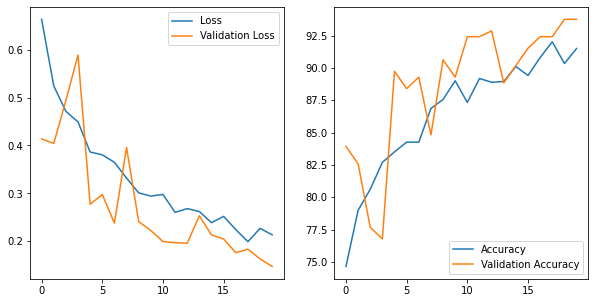

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(history.history['accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(history.history['val_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

### Prediction

first image to predict
actual label: COVID
predicted label: COVID


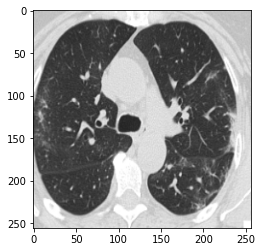

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[31].numpy().astype('uint8')
    first_label = labels_batch[31].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])